# ANALISI DATI ITALIA

In this notebook, we'll try analyse italian COVID-19 data gathered from *Dipartimento di Protezione Civile* GitHub repository ([link](https://github.com/pcm-dpc/COVID-19)).

We'll first create $x$ axes with datetime objects and $y$ axes with daily variations of
- confirmed cases
- recoveries
- deaths
- infected

where _infected_ are equal to _confirmed - (recoverd + deaths)_.

We won't reject outliers not loose any data, nor standardize or normalize data but we'll try to work with rough data only fitting them to gaussian curves (prime derivatives of the logistic growth curves) and try to get a forecast preview to 30 days.

In [42]:
import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
from numpy import exp, sqrt

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

First, let's define the gaussian function we'll use to fit data $$y = ae^{ \frac{-(x-b)^2}{c^2} }$$

In [43]:
def gauss_func(x, a, b, c):
    d = - ((x - b) ** 2)
    return a * exp( d / (c ** 2) )

and get the most recently updated data from D.P.C. GitHub repository, loading them into a dictionary:

In [44]:
json_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json"
with requests.get(json_ita) as req:
    data = json.loads(req.content.decode('utf-8-sig'))

Now, let's initialize $x$ and $y$ variables (we'll need also integer $x$ array to perform `curve_fit`)

In [45]:
x = []   # datetime x array
_x = []  # integer x array
yC = []  # new confirmed cases array
yD = []  # new deaths array
yR = []  # new recovered array
yP = []  # new infected array

For each data entry:
- append datetime object to `x`
- append integer to `_x`
- append new cases to $y$

We'll skip `data[0]` and get the first difference from `data[1]` on

In [46]:
for i, day in enumerate(data):
    if not i:
        pre = day
        continue
    date = dt.datetime.strptime(day["data"], "%Y-%m-%dT%H:%M:%S")
    # x values
    x.append(date)
    _x.append(i)
    # y values
    yC.append(day["totale_casi"] - pre["totale_casi"])
    yD.append(day["deceduti"] - pre["deceduti"])
    yR.append(day["dimessi_guariti"] - pre["dimessi_guariti"])
    yP.append(day["variazione_totale_positivi"])
    
    pre = day

Let's take a look to gathered data

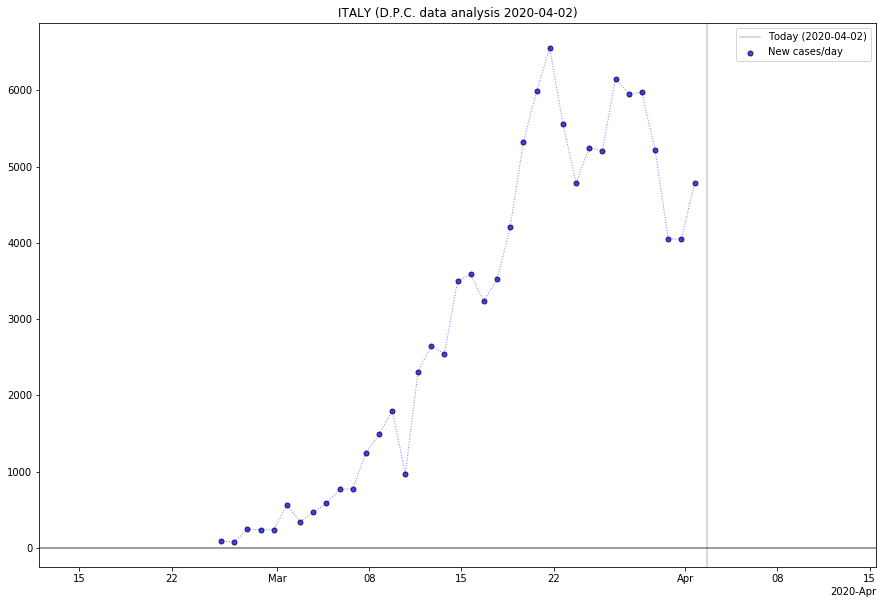

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yC, alpha=0.75, c="#0000ff",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

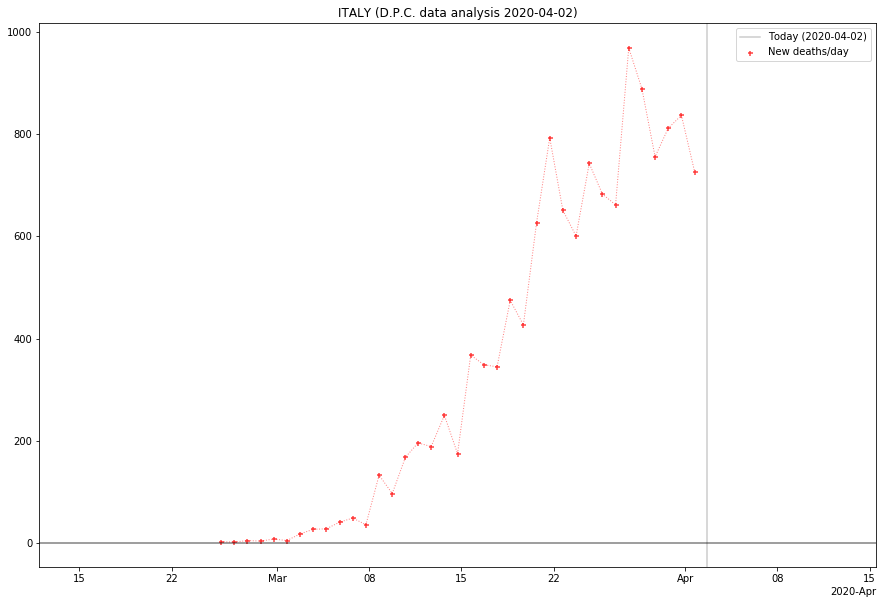

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="+", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

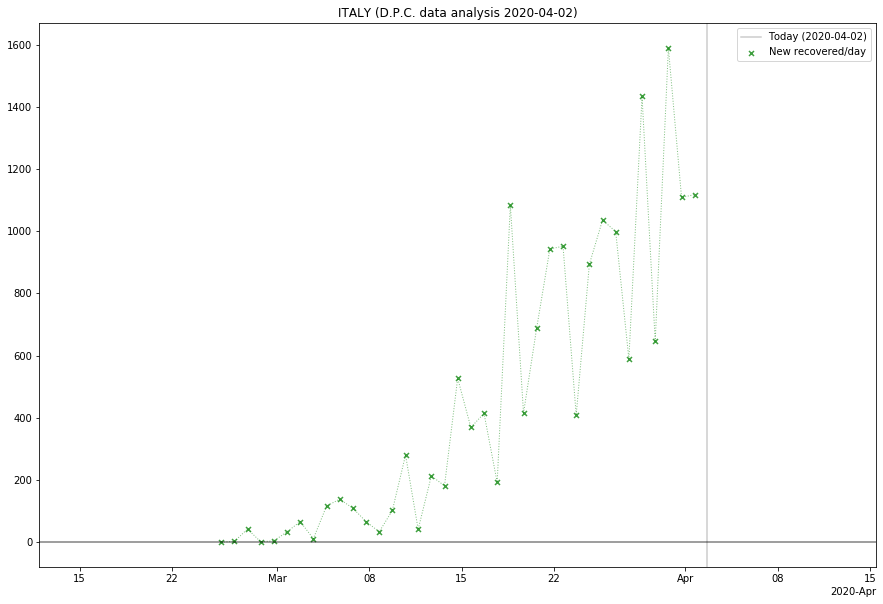

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="x", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

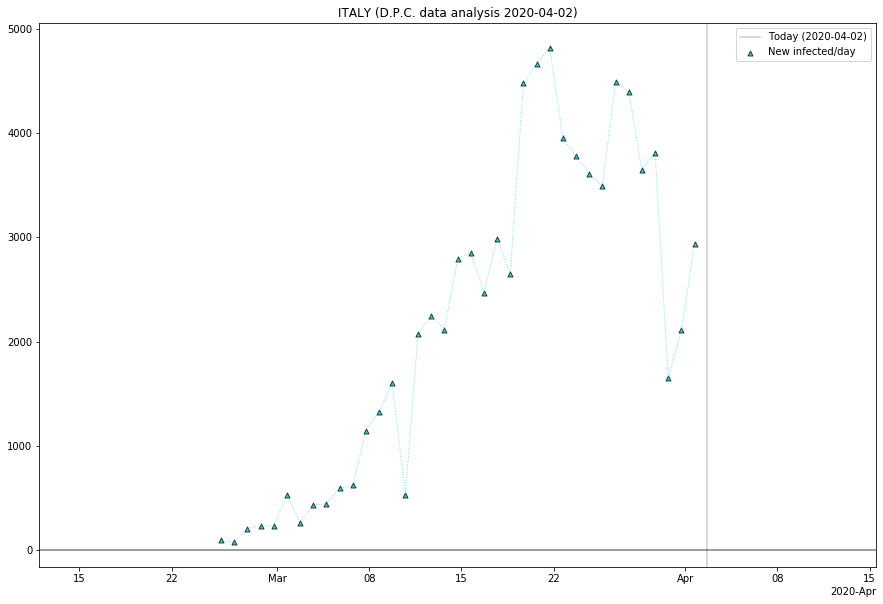

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

Let's now perform the `curve_fit` to the gaussian function with the known values (using integer array values `_x` instead of datetime `x`) to get `popt = (a, b, c)` parameters for each curve, guessing the maximum value of $y$ for $a$ parameter.

In [31]:
poptC, _ = curve_fit(gauss_func, _x, yC, p0=[max(yC), 1, 1])  # returns (a, b, c)
poptD, _ = curve_fit(gauss_func, _x, yD, p0=[max(yD), 1, 1])  # returns (a, b, c)
poptR, _ = curve_fit(gauss_func, _x, yR, p0=[max(yR), 1, 1])  # returns (a, b, c)
poptP, _ = curve_fit(gauss_func, _x, yP, p0=[max(yP), 1, 1])  # returns (a, b, c)

Here's what we found out

In [32]:
print("CONFIRMED\n\ta={}\n\tb={}\n\tc={}".format(*poptC))
display(Math(r"$y = {} \cdot e^{{ \frac{{ -(x - {})^2 }}{{ {}^2 }} }}$".format(*poptC)))

CONFIRMED
	a=5767.713741162343
	b=29.44717997965333
	c=-13.399969208419483


<IPython.core.display.Math object>

In [33]:
print("DEATHS\n\ta={}\n\tb={}\n\tc={}".format(*poptD))
display(Math(r"$y = {} \cdot e^{{ \frac{{ -(x - {})^2 }}{{ {}^2 }} }}$".format(*poptD)))

DEATHS
	a=819.1905789652408
	b=33.505988052313974
	c=13.764624296044982


<IPython.core.display.Math object>

In [34]:
print("RECOVERED\n\ta={}\n\tb={}\n\tc={}".format(*poptR))
display(Math(r"$y = {} \cdot e^{{ \frac{{ -(x - {})^2 }}{{ {}^2 }} }}$".format(*poptR)))

RECOVERED
	a=1158.1732644066249
	b=37.80280584995361
	c=16.866534239730164


<IPython.core.display.Math object>

In [35]:
print("INFECTED\n\ta={}\n\tb={}\n\tc={}".format(*poptP))
display(Math(r"$y = {} \cdot e^{{ \frac{{ -(x - {})^2 }}{{ {}^2 }} }}$".format(*poptP)))

INFECTED
	a=4146.692176129193
	b=27.709026537391722
	c=12.520988414227597


<IPython.core.display.Math object>

Let's now prepare `xg` array (datetime objects) and `_xg` array (integer values) for the forecast. We'll forecast 30 days from the last day `x[-1]`.

In [36]:
# forecast x datetime objects
xg = [x[-1] + dt.timedelta(days=d + 1) for d in range(30)]
xg = x + xg
# forecast x integer values
_xg = [_x[-1] + d + 1 for d in range(30)]
_xg = _x + _xg

Let's get the values of $y$ of the gaussian curves, till the end of the forecast.

In [37]:
yCg = gauss_func(_xg, *poptC)
yDg = gauss_func(_xg, *poptD)
yRg = gauss_func(_xg, *poptR)
yPg = gauss_func(_xg, *poptP)

Let's take a look to fitted gaussian curves

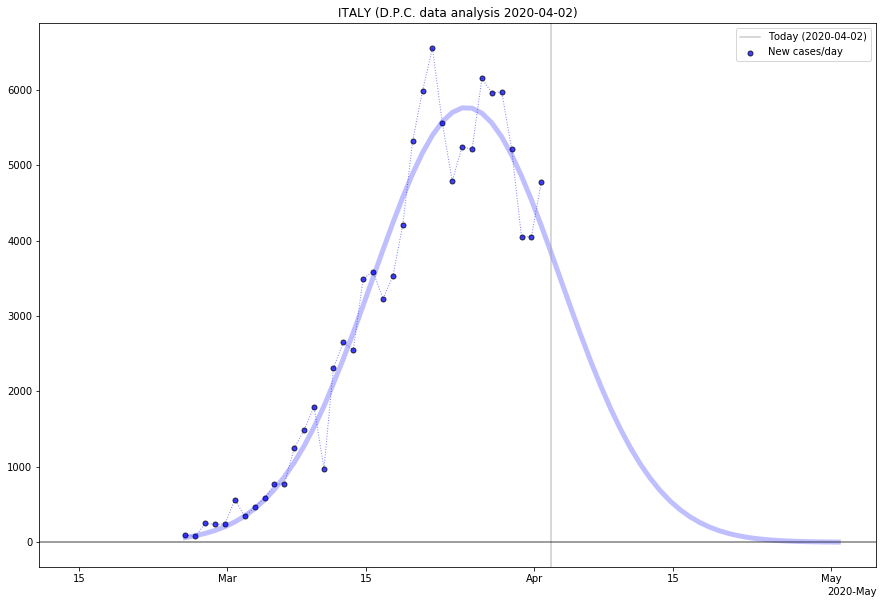

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yCg, alpha=0.25, c="b", linestyle="-", linewidth=5.0)

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

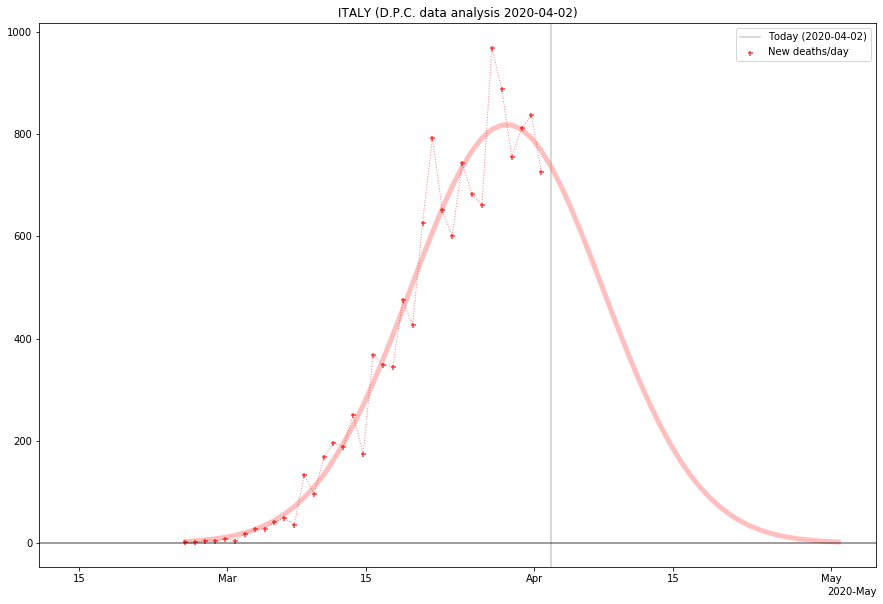

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="+", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yDg, alpha=0.25, c="r", linestyle="-", linewidth=5.0)

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

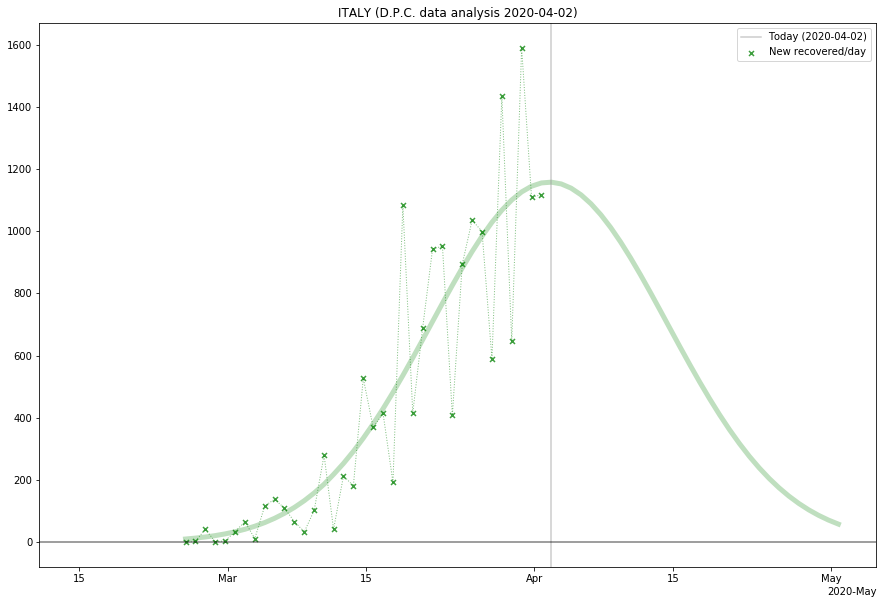

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="x", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yRg, alpha=0.25, c="g", linestyle="-", linewidth=5.0)

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

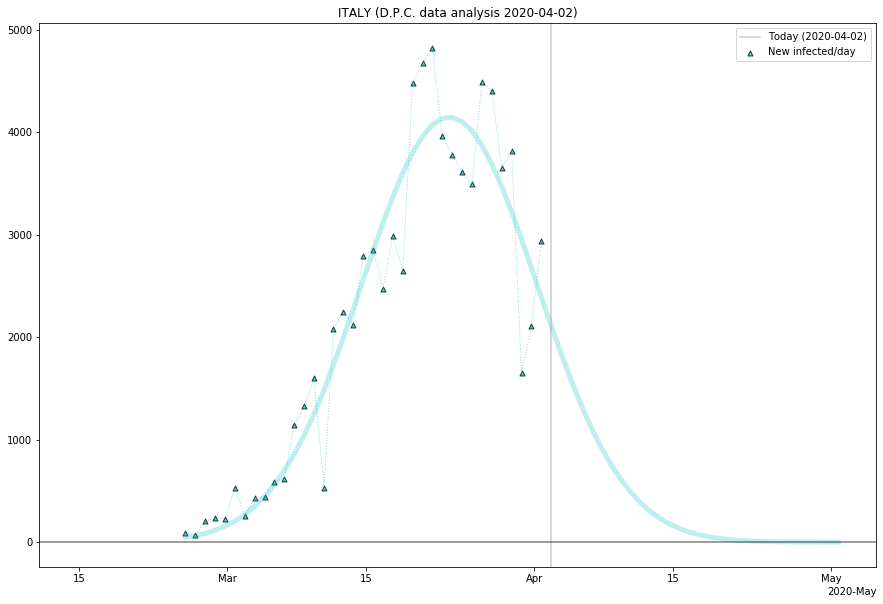

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yPg, alpha=0.25, c="c", linestyle="-", linewidth=5.0)

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')

For each $y$ array, let's now get
- the maximum $[x_{max}, y_{max}]$ coordinates
  - in the standard gaussian curve, maximum coordinates are $[\mu, f(\mu)]$, in our gaussian function will then be $[b, f(b)]$ so we need to add $b - 1$ days to first $x_0$ date ($b - 1$ and not $b$ because we skeepped $x_0$) and calculate $y_{max} = f(b)$ with known parameters $(a, b, c)$
- the flexes $[x_{flex}, y_{flex}]$ coordinates
  - the two flexes will obiviously be $[b-\sigma, f(b-\sigma)]$ and $[b+\sigma, f(b+\sigma)]$, so we first need to calculate $\sigma$ (the standard deviation):
    - $\sigma$ in our gaussian curve is equal to $c/\sqrt{2}$
- the guessed _~0 events/day_ i.e. the day we could expect to have _almost_ no new event per day. We could choose this day as $\mu$ (the maximum, $b$) + three standard deviations $x_{0 cases} = b + 3\sigma$

In [22]:
# CONFIRMED CASES
a, b, c = poptC
# the maximum x coordinate, datetime object
muC = x[0] + dt.timedelta(days=abs(b) - 1)
# the maximum x coordinate, integer value
_muC = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuC = gauss_func(_muC, *poptC)
# calculate sigma
siC = abs(c / sqrt(2))
# 1st flex coordinates
f1C = muC - dt.timedelta(days=siC)
yf1C = gauss_func(_muC - siC, *poptC)
# 2nd flex coordinates
f2C = muC + dt.timedelta(days=siC)
yf2C = gauss_func(_muC + siC, *poptC)
# x coordinate of ~0 events/day
noC = muC + dt.timedelta(days=(3 * siC))

Let's do the same for the other curves

In [23]:
# DEATHS
a, b, c = poptD
muD = x[0] + dt.timedelta(days=abs(b) - 1)
_muD = _xg[0] + abs(b) - 1
ymuD = gauss_func(_muD, *poptD)
siD = abs(c / sqrt(2))
f1D = muD - dt.timedelta(days=siD)
yf1D = gauss_func(_muD - siD, *poptD)
f2D = muD + dt.timedelta(days=siD)
yf2D = gauss_func(_muD + siD, *poptD)
noD = muD + dt.timedelta(days=(3 * siD))

# RECOVERED
a, b, c = poptR
muR = x[0] + dt.timedelta(days=abs(b) - 1)
_muR = _xg[0] + abs(b) - 1
ymuR = gauss_func(_muR, *poptR)
siR = abs(c / sqrt(2))
f1R = muR - dt.timedelta(days=siR)
yf1R = gauss_func(_muR - siR, *poptR)
f2R = muR + dt.timedelta(days=siR)
yf2R = gauss_func(_muR + siR, *poptR)
noR = muR + dt.timedelta(days=(3 * siR))

# INFECTED
a, b, c = poptP
muP = x[0] + dt.timedelta(days=abs(b) - 1)
_muP = _xg[0] + abs(b) - 1
ymuP = gauss_func(_muP, *poptP)
siP = abs(c / sqrt(2))
f1P = muP - dt.timedelta(days=siP)
yf1P = gauss_func(_muP - siP, *poptP)
f2P = muP + dt.timedelta(days=siP)
yf2P = gauss_func(_muP + siP, *poptP)
noP = muP + dt.timedelta(days=(3 * siP))

Let's look each single plot with maximum, flexes and guessed ~0 events/day dates

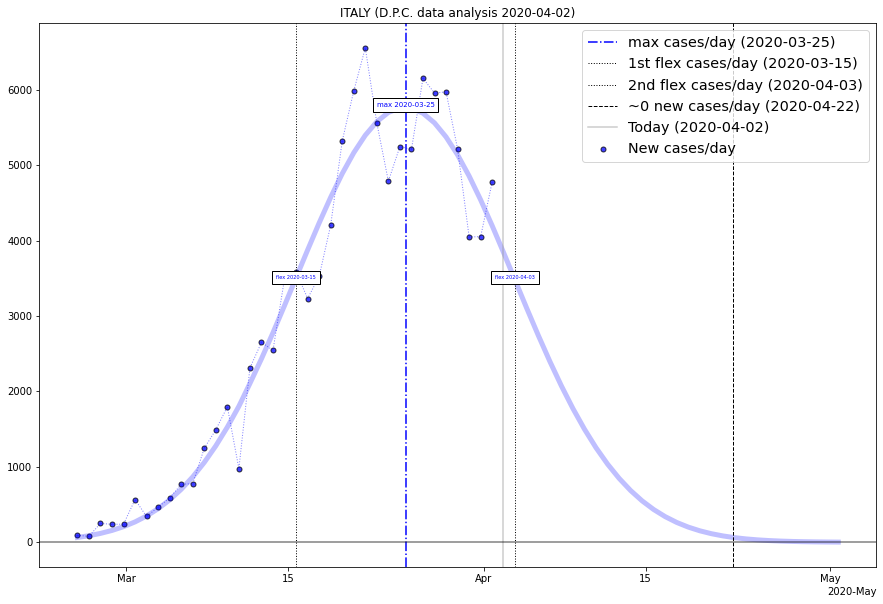

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yCg, alpha=0.25, c="b", linestyle="-", linewidth=5.0)
# maximum and flexes
plt.axvline(x=muC, linestyle="-.", color="b", label="max cases/day ({})".format(muC.strftime("%Y-%m-%d")))
plt.text(muC, ymuC, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")
plt.axvline(x=f1C, linestyle=":", color="k", label="1st flex cases/day ({})".format(f1C.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f1C, yf1C, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")
plt.axvline(x=f2C, linestyle=":", color="k", label="2nd flex cases/day ({})".format(f2C.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f2C, yf2C, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")
# ~0 cases/day date vertical line 
plt.axvline(x=noC, color="k", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="b", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='x-large')

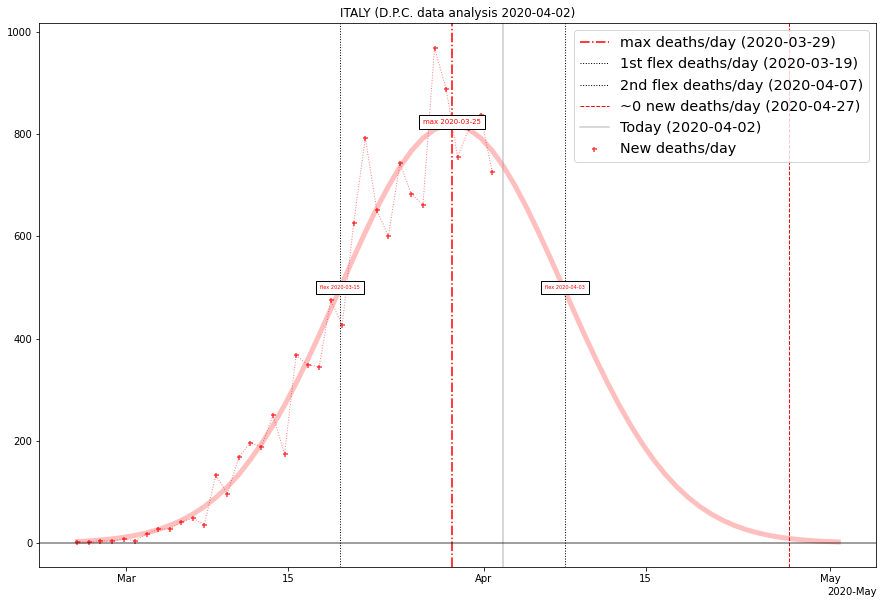

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="+", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yDg, alpha=0.25, c="r", linestyle="-", linewidth=5.0)
# maximum and flexes
plt.axvline(x=muD, linestyle="-.", color="r", label="max deaths/day ({})".format(muD.strftime("%Y-%m-%d")))
plt.text(muD, ymuD, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")
plt.axvline(x=f1D, linestyle=":", color="k", label="1st flex deaths/day ({})".format(f1D.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f1D, yf1D, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")
plt.axvline(x=f2D, linestyle=":", color="k", label="2nd flex deaths/day ({})".format(f2D.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f2D, yf2D, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")
# ~0 cases/day date vertical line 
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='x-large')

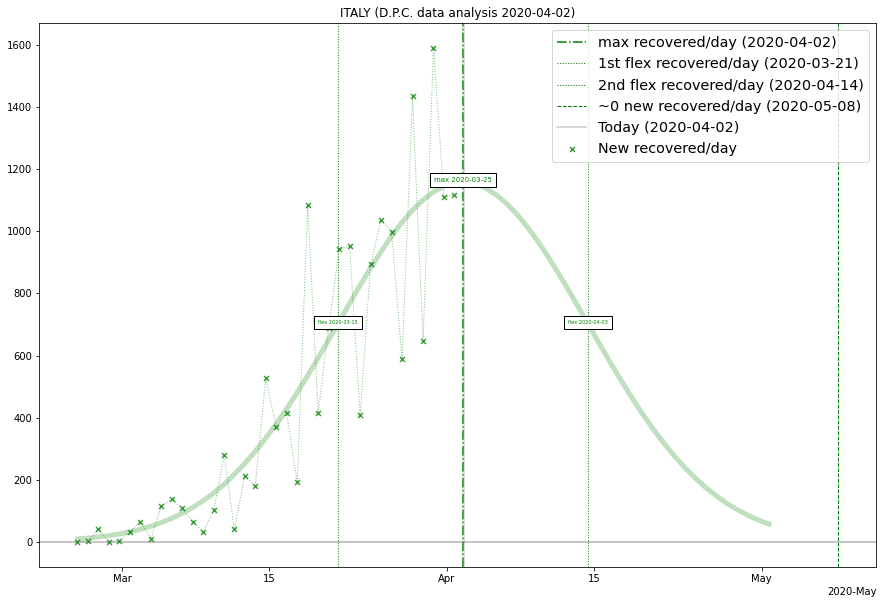

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="x", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yRg, alpha=0.25, c="g", linestyle="-", linewidth=5.0)
# maximum and flexes
plt.axvline(x=muR, linestyle="-.", color="g", label="max recovered/day ({})".format(muR.strftime("%Y-%m-%d")))
plt.text(muR, ymuR, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")
plt.axvline(x=f1R, linestyle=":", color="k", label="1st flex recovered/day ({})".format(f1R.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f1R, yf1R, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")
plt.axvline(x=f2R, linestyle=":", color="k", label="2nd flex recovered/day ({})".format(f2R.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f2R, yf2R, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")
# ~0 cases/day date vertical line 
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='x-large')

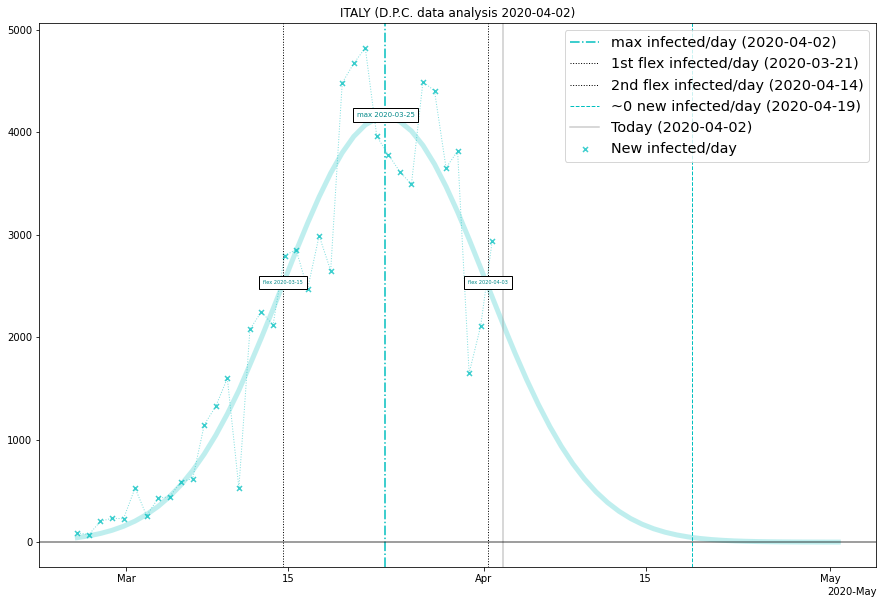

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="x", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yPg, alpha=0.25, c="c", linestyle="-", linewidth=5.0)
# maximum and flexes
plt.axvline(x=muP, linestyle="-.", color="c", label="max infected/day ({})".format(muR.strftime("%Y-%m-%d")))
plt.text(muP, ymuP, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="#008888")
plt.axvline(x=f1P, linestyle=":", color="k", label="1st flex infected/day ({})".format(f1R.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f1P, yf1P, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="#008888")
plt.axvline(x=f2P, linestyle=":", color="k", label="2nd flex infected/day ({})".format(f2R.strftime("%Y-%m-%d")), linewidth=1.0)
plt.text(f2P, yf2P, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="#008888")
# ~0 cases/day date vertical line 
plt.axvline(x=noP, color="c", linestyle="--", linewidth=1.0, label="~0 new infected/day ({})".format(noP.strftime("%Y-%m-%d")))

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='x-large')

And finally look to the complete result:

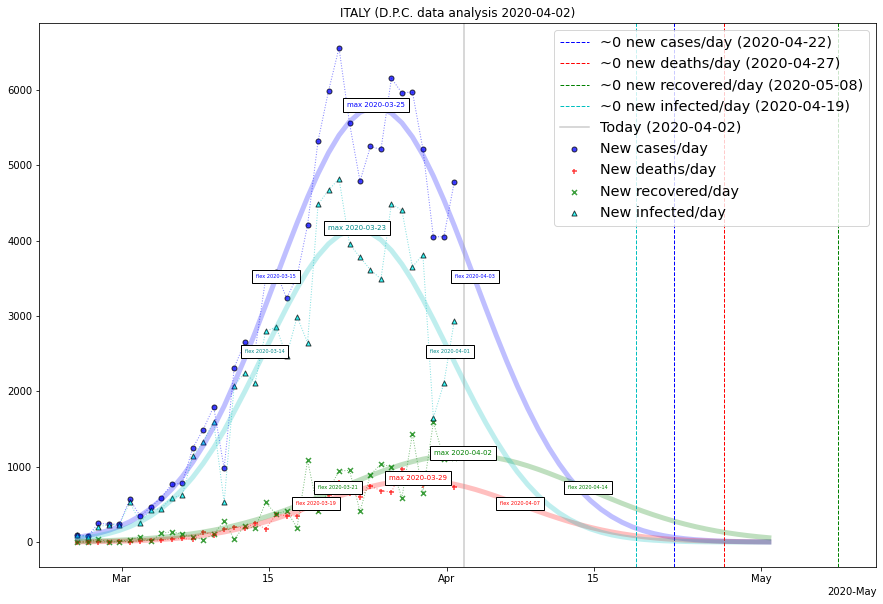

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# CONFIRMED
# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg, yCg, alpha=0.25, c="b", linestyle="-", linewidth=5.0)
# maximum and flexes text boxes
plt.text(muC, ymuC, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")
plt.text(f1C, yf1C, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")
plt.text(f2C, yf2C, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")
# ~0 cases/day date vertical line 
plt.axvline(x=noC, color="b", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))

# DEATHS
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="+", s=25, label="New deaths/day")
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)
ax.plot(xg, yDg, alpha=0.25, c="r", linestyle="-", linewidth=5.0)
plt.text(muD, ymuD, "max " + muD.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")
plt.text(f1D, yf1D, "flex " + f1D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")
plt.text(f2D, yf2D, "flex " + f2D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))

# RECOVERED
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="x", s=25, label="New recovered/day")
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
ax.plot(xg, yRg, alpha=0.25, c="g", linestyle="-", linewidth=5.0)
plt.text(muR, ymuR, "max " + muR.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")
plt.text(f1R, yf1R, "flex " + f1R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")
plt.text(f2R, yf2R, "flex " + f2R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))

# INFECTED
ax.scatter(x, yP, alpha=0.75, c="#00ffff",edgecolors='#000000', marker="^", s=25, label="New infected/day")
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
ax.plot(xg, yPg, alpha=0.25, c="c", linestyle="-", linewidth=5.0)
plt.text(muP, ymuP, "max " + muP.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="#008888")
plt.text(f1P, yf1P, "flex " + f1P.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="#008888")
plt.text(f2P, yf2P, "flex " + f2P.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="#008888")
plt.axvline(x=noP, color="c", linestyle="--", linewidth=1.0, label="~0 new infected/day ({})".format(noP.strftime("%Y-%m-%d")))

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='x-large')